<a href="https://colab.research.google.com/github/DamienGulliver/Institute_of_data/blob/main/capstone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA DESCRIPTION

In [1]:
from google.colab import files
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
PROJECT_ID = 'effnet-moa'
BUCKET_NAME = 'effnet-moa'
DATA_DIR = 'gs://effnet-moa'
RAND_SEED = 42

In [3]:
# Set up google credentials to access GCS bucket

from google.colab import auth
auth.authenticate_user()

!gcloud config set project {PROJECT_ID}
!gsutil ls

Updated property [core/project].
gs://effnet-moa/


In [4]:
!gsutil cp gs://{BUCKET_NAME}/capstone_raw_data/lish-moa.zip /content/lish-moa.zip

Copying gs://effnet-moa/capstone_raw_data/lish-moa.zip...
\ [1 files][ 64.7 MiB/ 64.7 MiB]                                                
Operation completed over 1 objects/64.7 MiB.                                     


In [5]:
# Unzip raw data into working directory

!unzip "/content/lish-moa.zip" -d "/content/"

Archive:  /content/lish-moa.zip
replace /content/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/sample_submission.csv  
  inflating: /content/test_features.csv  
  inflating: /content/train_drug.csv  
  inflating: /content/train_features.csv  
  inflating: /content/train_targets_nonscored.csv  
  inflating: /content/train_targets_scored.csv  


In [6]:
# Read csv files into dataframes

features = pd.read_csv('/content/train_features.csv', engine='c')
targets = pd.read_csv('/content/train_targets_scored.csv', engine='c')
drugs = pd.read_csv('/content/train_drug.csv', engine='c')

features.name = 'Features'
targets.name = 'Targets'
drugs.name = 'Drugs'

In [7]:
for df in [features, targets, drugs]:
  print(df.name, 'shape:', df.shape, ', null values:', df.isnull().values.any(),', index values unique:', df.index.is_unique)

Features shape: (23814, 876) , null values: False , index values unique: True
Targets shape: (23814, 207) , null values: False , index values unique: True
Drugs shape: (23814, 2) , null values: False , index values unique: True


In [8]:
# check that sig_id matches in train and targets datasets (empty list = everything ok)

rows = []
for i, row in targets.iterrows():
    if row.sig_id not in features.sig_id.values:
        rows.append(row)
        
print(rows)

[]


In [9]:
# features contains a unique identifier, the treatment type, duration and dose, gene expression changes and cell viability profiles after treatment with different drugs

features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [10]:
# targets contains one-hot encoded target classes (indicating proteins, enzymes and receptors). 
# 0 = no activity (no MoA)
# 1 = active (MoA) 

targets.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Drugs can have up to 7 MoAs, making this a multi-label classification problem
# Most drugs have 1 MoA
# Some drugs have no MoA

target_counts = np.sum(targets.drop('sig_id', axis=1), axis=1)
print('min MoAs:', target_counts.min())
print( 'mean MoAs:', target_counts.mean())
print('max MoAs:', target_counts.max())

min MoAs: 0
mean MoAs: 0.7073150247753422
max MoAs: 7


In [12]:
# Targets are activated by up to 832 different treatments/sig_ids (potentially the same drug at different dosages, durations and cell types)
# All targets are activated at least once
# Each target is activated by 82 different treatments in the dataset on average

target_activations = np.sum(targets.drop(['sig_id'], axis=1), axis=0)
print('min target activations:', target_activations.min())
print( 'mean target activations:', target_activations.mean())
print('max target activations:', target_activations.max())

min target activations: 1
mean target activations: 81.76699029126213
max target activations: 832


In [13]:
# drugs contains drug_ids matched with unique identifiers, probably indicating different treatment durations and doses

drugs.head()

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


In [14]:
# drugs have an average of 7 different treatments (sig_ids) associated with them, indicating different treatment dosages and duration.
# min 1 and max 1866 sig_ids associated with each drug_id (seemingly very large number)

group = drugs.groupby('drug_id')['sig_id'].count().sort_values()
group.describe().T

count    3289.000000
mean        7.240499
std        35.901370
min         1.000000
25%         6.000000
50%         6.000000
75%         6.000000
max      1866.000000
Name: sig_id, dtype: float64

In [15]:
# drug_id with 1866 observations is cacb2b860

group = pd.DataFrame(group)
group.tail()

,sig_id
drug_id,
5628cb3ee,202
8b87a7a83,203
9f80f3f77,246
87d714366,718
cacb2b860,1866


In [16]:
# combine features, targets and drugs into a single dataset based on sig_id

for df in [features, targets, drugs]:
  df.set_index('sig_id', inplace=True)

df = features.join(targets)
df = df.join(drugs)

df.shape

df.reset_index(inplace=True)

In [17]:
# Checking out drug_id cacb2b860 to see what its associated with

df2 = df.loc[df['drug_id'].str.contains('cacb2b860')]
df2

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,drug_id
25,id_0054388ec,ctl_vehicle,48,D1,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0,0,0,0,0,0,0,0,0,cacb2b860
38,id_0079af0fb,ctl_vehicle,24,D1,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,0,0,0,0,0,0,0,0,0,cacb2b860
40,id_007bfbb91,ctl_vehicle,24,D2,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,0,0,0,0,0,0,0,0,0,cacb2b860
47,id_008a986b7,ctl_vehicle,48,D2,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,0,0,0,0,0,0,0,0,0,cacb2b860
63,id_009d8340f,ctl_vehicle,24,D2,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0,0,0,0,0,0,0,0,0,cacb2b860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,ctl_vehicle,24,D1,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0,0,0,0,0,0,0,0,0,cacb2b860
23747,id_ff469c482,ctl_vehicle,72,D1,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0,0,0,0,0,0,0,0,0,cacb2b860
23768,id_ff89331ca,ctl_vehicle,72,D2,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0,0,0,0,0,0,0,0,0,cacb2b860
23793,id_ffd26f361,ctl_vehicle,48,D2,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0,0,0,0,0,0,0,0,0,cacb2b860


In [18]:
# This drug_id indicates ctl_vehicle (negative control for experiment, probably water or cell-growth buffer solution)

df2['cp_type'].value_counts()

ctl_vehicle    1866
Name: cp_type, dtype: int64

In [19]:
# check feature types

filter_gene = [col for col in features if col.startswith('g-')]
filter_cell = [col for col in features if col.startswith('c-')]

print('number of gene expression features: ', len(filter_gene))
print('number of cell viability features: ', len(filter_cell))

number of gene expression features:  772
number of cell viability features:  100


In [20]:
# check sparsity of targets dataframe

sparsity = sum((targets == 0).astype(int).sum())/targets.size
sparsity

0.9965664319185663

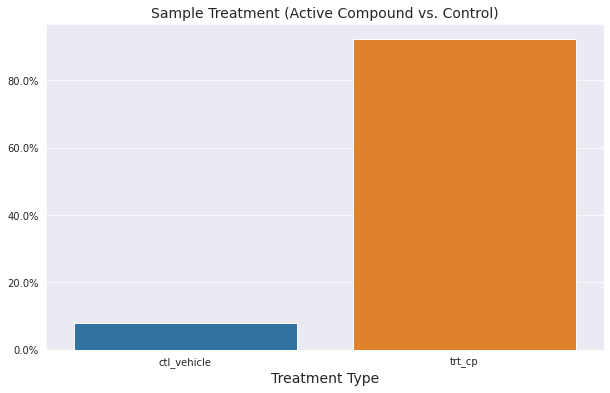

In [21]:
# Many more treatment molecules vs. control molecules

cp_type = df.groupby('cp_type')['sig_id'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=cp_type.index, y=cp_type.values / cp_type.sum())
plt.title('Sample Treatment (Active Compound vs. Control)', fontsize=14)
plt.xlabel('Treatment Type', fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False))
#plt.gca().bar_label(plot.containers[0], labels=cp_type.values, label_type='edge')

# save fig
#plt.savefig('sample_treatment.svg')
#files.download('sample_treatment.svg')
#!gsutil -m cp /content/sample_treatment.svg gs://{BUCKET_NAME}/capstone_figures/

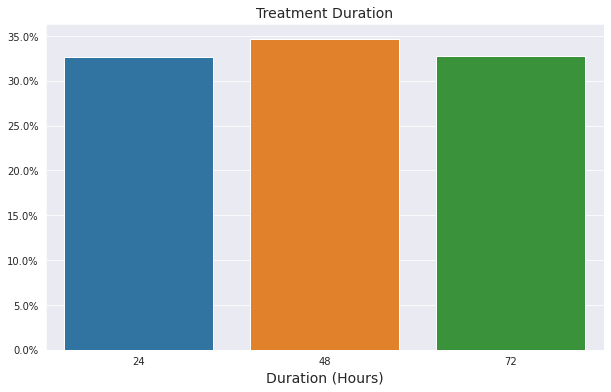

In [22]:
# Roughly equal proportion of treatment durations across dataset (24, 48, 72h)

cp_time = df.groupby('cp_time')['sig_id'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=cp_time.index, y=cp_time.values / cp_time.sum())
plt.gca().set_title('Treatment Duration', fontsize=14)
plt.xlabel('Duration (Hours)', fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False))
#plt.gca().bar_label(plot.containers[0], labels=cp_type.values, label_type='edge')

#plt.show()

# save fig
#plt.savefig('treatment_duration.svg')
#files.download('treatment_duration.svg')
#!gsutil -m cp /content/treatment_duration.svg gs://{BUCKET_NAME}/capstone_figures/

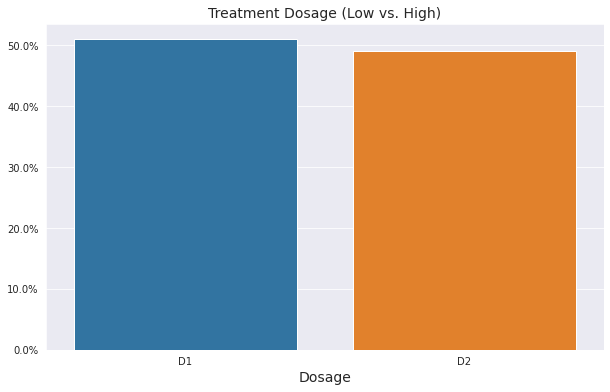

In [23]:
# Roughly equal proportion of treatment dosages across dataset (low vs. high)
# Doesn't indicate actual dosage of drug, potency of drugs may vary so this is a limitation of the dataset

cp_dose = df.groupby('cp_dose')['sig_id'].count()

plt.figure(figsize=(10, 6))
sns.barplot(x=cp_dose.index, y=cp_dose.values / cp_dose.sum())
plt.gca().set_title('Treatment Dosage (Low vs. High)', fontsize=14)
plt.xlabel('Dosage', fontsize=14)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1, symbol='%', is_latex=False))
#plt.gca().bar_label(plot.containers[0], labels=cp_type.values, label_type='edge')

#plt.show()

# save fig
#plt.savefig('treatment_dosage.svg')
#files.download('treatment_dosage.svg')
#!gsutil -m cp /content/treatment_dosage.svg gs://{BUCKET_NAME}/capstone_figures/

Text(0.5, 0.98, 'Gene Expression Features Distribution')

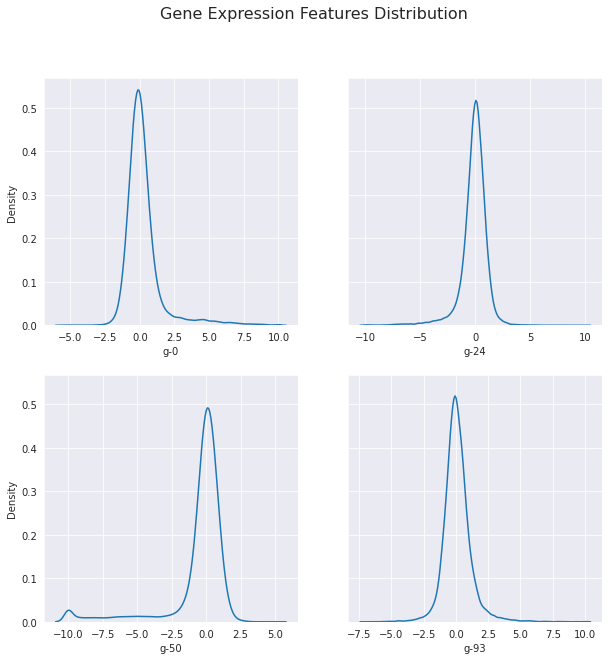

In [24]:
# Looking at the distribution for 4 random gene expression features - looks like mean is centred over zero with tails that extend from -10:10 

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True)

sns.kdeplot(ax=axes[0,0], data=features, x='g-0')
sns.kdeplot(ax=axes[0,1], data=features, x='g-24')
sns.kdeplot(ax=axes[1,0], data=features, x='g-50')
sns.kdeplot(ax=axes[1,1], data=features, x='g-93')

fig.suptitle('Gene Expression Features Distribution', fontsize=16)

#plt.show()

# save fig
#plt.savefig('gene_distribution.svg')
#files.download('gene_distribution.svg')
#!gsutil -m cp /content/gene_distribution.svg gs://{BUCKET_NAME}/capstone_figures/

Text(0.5, 0.98, 'Cell Viability Features Distribution')

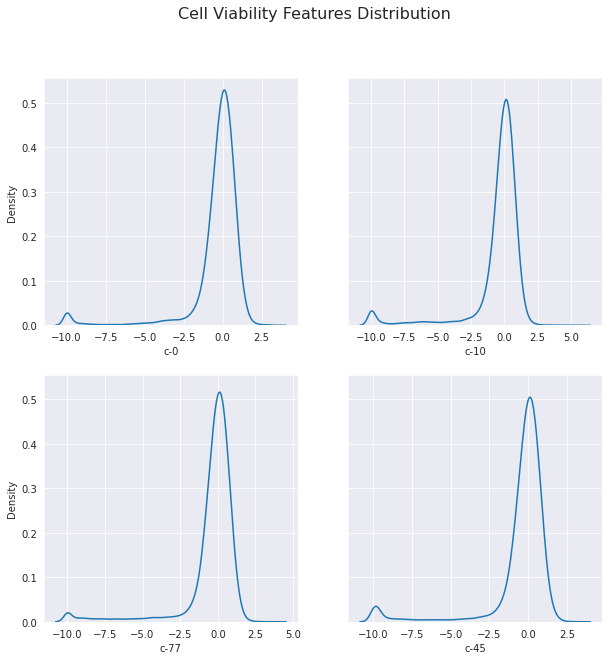

In [25]:
# Looking at the distribution for 4 random cell viability features - looks like mean is centred over zero with a consistent tail and peak in values at -10
# Given that these are cell viability features, -10 may indicate 100% cell death following drug treatment (0% viability). 
# This peak is probably significant and may indicate toxic molecules

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True)

sns.kdeplot(ax=axes[0,0], data=features, x='c-0')
sns.kdeplot(ax=axes[0,1], data=features, x='c-10')
sns.kdeplot(ax=axes[1,0], data=features, x='c-77')
sns.kdeplot(ax=axes[1,1], data=features, x='c-45')

fig.suptitle('Cell Viability Features Distribution', fontsize=16)

#plt.show()

# save fig
#plt.savefig('cell_viability.svg')
#files.download('cell_viability.svg')
#!gsutil -m cp /content/cell_viability.svg gs://{BUCKET_NAME}/capstone_figures/

In [26]:
# Creat new column for target activations

targets.reset_index(inplace=True)
targets['activations'] = target_counts
targets_activated = targets.groupby('activations')['sig_id'].count()

In [27]:
labels = np.round((targets_activated.values / targets_activated.sum()), 4)
labels = labels.tolist()
labels = ["{:.2%}".format(x) for x in labels]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

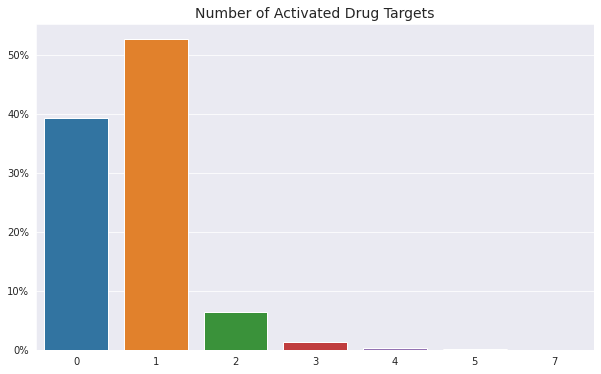

In [31]:
plt.figure(figsize=(10,6))

plt.gca().set_title('Number of Activated Drug Targets', fontsize=14)
plot = sns.barplot(x=targets_activated.index, y=targets_activated.values / targets_activated.sum())
plt.xlabel('', fontsize=14)
plot.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0, symbol='%', is_latex=False))
#plot.bar_label(plot.containers[0], labels = labels, label_type='edge')

#plt.show()

# save fig
#plt.savefig('activations.svg')
#files.download('activations.svg')
#!gsutil -m cp /content/activations.svg gs://{BUCKET_NAME}/capstone_figures/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

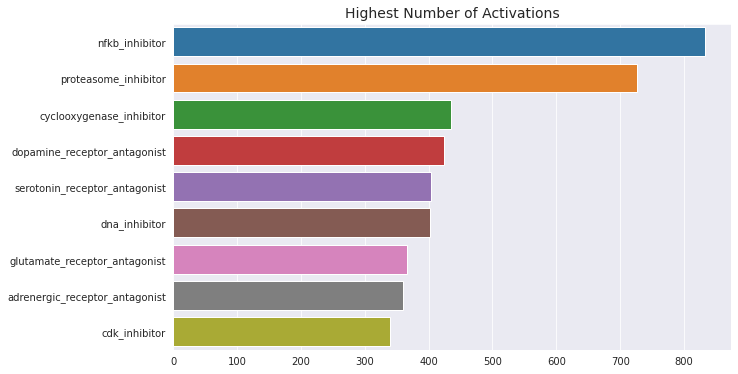

In [36]:
sorted_activations = target_activations.sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.gca().set_title('Highest Number of Activations', fontsize=14)
sns.barplot(y=sorted_activations[0:9].index, x=sorted_activations[0:9].values)

#plt.show()

# save fig
plt.savefig('target_activations.svg', bbox_inches='tight')
files.download('target_activations.svg')
#!gsutil -m cp /content/target_activations.svg gs://{BUCKET_NAME}/capstone_figures/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

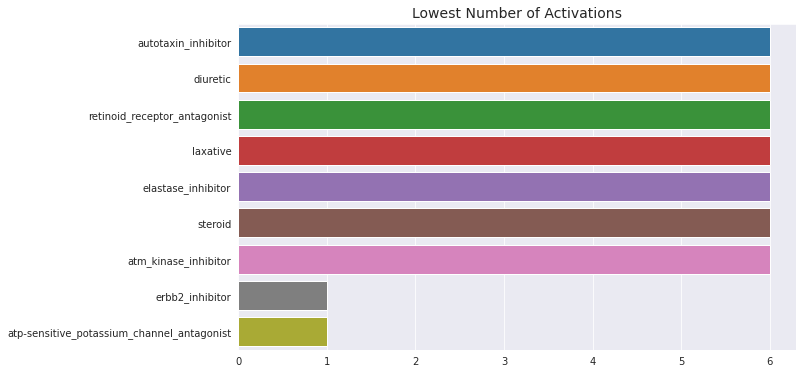

In [35]:
plt.figure(figsize=(10,6))

sns.barplot(y=sorted_activations[-9:].index, x=sorted_activations[-9:].values)
plt.gca().set_title('Lowest Number of Activations', fontsize=14)

#plt.show()

# save fig
plt.savefig('target_lowest_activations.svg', bbox_inches='tight')
files.download('target_lowest_activations.svg')
#!gsutil -m cp /content/target_lowest_activations.svg gs://{BUCKET_NAME}/capstone_figures/